In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix
from sklearn.linear_model import Ridge
from nba_api.stats.static import players
from nba_api.stats.static import teams

# Update directory path
os.chdir('/Users/graallen/Documents/Personal Docs/Grad School/fall_2024/ds_785/capstone')
os.environ["GRB_LICENSE_FILE"] = 'gurobi.lic'

from import_lineups_final import lineups_df

### Get the best model for our lineup plus-minus estimates

In [2]:
player_spm = pd.read_csv("best_model_predictions.csv")
player_spm['spm'] = player_spm['ospm'] + player_spm['dspm']
# lineup_model = pd.read_csv("lineup_rapm.csv")

### Transform the lineup data to get some raw performance on the lineup

In [3]:
lineups_df['home_lineup'] = lineups_df['players'].apply(lambda x: tuple(sorted(x[:5])))
lineups_df['away_lineup'] = lineups_df['players'].apply(lambda x: tuple(sorted(x[5:])))

In [4]:
# Create stats for home lineups
home_lineups = lineups_df.groupby(['season','home_team','home_lineup','home_possession']).agg(
    possessions=('game_possession', 'size'),
    points=('points', 'sum')
).reset_index()
home_lineups = home_lineups.pivot_table(index=['season', 'home_team', 'home_lineup'], columns='home_possession', values=['possessions','points']).reset_index()
home_lineups.columns.name = None
home_lineups.columns = ['season', 'home_team', 'home_lineup', 'home_points_against', 'home_points_for', 'home_possessions_against', 'home_possessions_for']

# Create stats for away lineups
away_lineups = lineups_df.groupby(['season','away_team','away_lineup','home_possession']).agg(
    possessions=('game_possession', 'size'),
    points=('points', 'sum')
).reset_index()

away_lineups = away_lineups.pivot_table(index=['season', 'away_team', 'away_lineup'], columns='home_possession', values=['possessions','points']).reset_index()
away_lineups.columns.name = None
away_lineups.columns = ['season', 'away_team', 'away_lineup', 'away_points_for', 'away_points_against', 'away_possessions_for', 'away_possessions_against']

In [5]:
# let's look at points per possession for a specific lineup at home vs. away - do we see the same trend
nba_lineups = pd.merge(home_lineups, away_lineups, how='outer', left_on=['season','home_team','home_lineup'], right_on=['season','away_team','away_lineup'])

# Create the lineup column based on home_lineup and away_lineup
nba_lineups['lineup'] = nba_lineups.apply(
    lambda row: row['home_lineup'] if pd.notna(row['home_lineup']) else row['away_lineup'], axis=1
)

# Create the team column based on home_team and away_team
nba_lineups['team_id'] = nba_lineups.apply(
    lambda row: row['home_team'] if pd.notna(row['home_team']) else row['away_team'], axis=1
)

# Drop the home_lineup and away_lineup columns 
nba_lineups = nba_lineups.drop(columns=['home_lineup', 'away_lineup'])
nba_lineups = nba_lineups.drop(columns=['home_team', 'away_team'])

# fill all the NaN values up to now with 0
nba_lineups = nba_lineups.fillna(0)

# Create new total columns based on home and away splits
nba_lineups['total_possessions_for'] = nba_lineups['home_possessions_for'] + nba_lineups['away_possessions_for']
nba_lineups['total_possessions_against'] = nba_lineups['home_possessions_against'] + nba_lineups['away_possessions_against']
nba_lineups['total_points_for'] = nba_lineups['home_points_for'] + nba_lineups['away_points_for']
nba_lineups['total_points_against'] = nba_lineups['home_points_against'] + nba_lineups['away_points_against']
nba_lineups['home_ppp_for'] = nba_lineups['home_points_for']/nba_lineups['home_possessions_for']
nba_lineups['home_ppp_against'] = nba_lineups['home_points_against']/nba_lineups['home_possessions_against']
nba_lineups['away_ppp_for'] = nba_lineups['away_points_for']/nba_lineups['away_possessions_for']
nba_lineups['away_ppp_against'] = nba_lineups['away_points_against']/nba_lineups['away_possessions_against']
nba_lineups['total_ppp_for'] = nba_lineups['total_points_for']/nba_lineups['total_possessions_for']
nba_lineups['total_ppp_against'] = nba_lineups['total_points_against']/nba_lineups['total_possessions_against']
nba_lineups['home_pm_p100'] = (nba_lineups['home_ppp_for']-nba_lineups['home_ppp_against'])*100
nba_lineups['away_pm_p100'] = (nba_lineups['away_ppp_for']-nba_lineups['away_ppp_against'])*100
nba_lineups['total_pm_p100'] = (nba_lineups['total_ppp_for']-nba_lineups['total_ppp_against'])*100

In [6]:
# Get the player and team names
nba_players = players.get_players()
nba_players = pd.DataFrame(nba_players)

nba_teams = teams.get_teams()
nba_teams = pd.DataFrame(nba_teams)

# Create a dictionary from the nba_players and nba_teams DataFrame for quick lookup
nba_players_dict = nba_players.set_index('id')['full_name'].to_dict()
nba_teams_dict = nba_teams.set_index('id')['abbreviation'].to_dict()

# Function to get player names from the lineup tuple
def get_player_names(lineup):
    return [nba_players_dict[player_id] for player_id in lineup]

def get_team_names(team_id):
    return nba_teams_dict[team_id]

# Apply the function to create new columns
#lineups['season'] = lineups['season'].apply(get_season)
nba_lineups['team'] = nba_lineups['team_id'].apply(get_team_names)
nba_lineups[['p1', 'p2', 'p3', 'p4', 'p5']] = nba_lineups['lineup'].apply(get_player_names).apply(pd.Series)

In [7]:
# Function to create a new dictionary with player IDs from the set and their MPG
def create_mpg_dict(player_ids, mpg_dict):
    return {(player_id): mpg for (player_id), mpg in mpg_dict.items() if player_id in player_ids}

# Function to calculate total SPM for a lineup
def calculate_player_spm(row, player_spm):
    season = row['season']
    lineup = row['lineup']
    
    # Fetch rapm values for each player in the lineup
    spm_values = [
        player_spm.loc[(player_spm['player_id'] == player_id) & (player_spm['season'] == season), 'spm'].values[0]
        for player_id in lineup
        if not player_spm.loc[(player_spm['player_id'] == player_id) & (player_spm['season'] == season), 'spm'].empty
    ]
    
    # Calculate the total SPM for the lineup
    return sum(spm_values)

### Filter to team and season we are interested in optimizing for

In [25]:
# get the boston lineups from last season and start actually building the lineup optimizer
filter_list = (
                (nba_lineups['season']==22023) & 
                (nba_lineups['team']=='BOS') 
              ) 
num_lineups = nba_lineups[filter_list].shape[0]
print(num_lineups," Lineups")
team_df = nba_lineups[filter_list].sort_values(by=['total_possessions_for'], ascending=False).reset_index(drop=True)
team_df = team_df[['season','team','lineup','p1','p2','p3','p4','p5','total_pm_p100','total_possessions_for','total_possessions_against','total_points_for','total_points_against']]

team_avg = team_df.groupby(['team','season']).agg(
    total_possessions_for=('total_possessions_for', 'sum'),
    total_possessions_against=('total_possessions_against', 'sum'),
    total_points_for=('total_points_for', 'sum'),
    total_points_against=('total_points_against', 'sum')
).reset_index()

team_avg_pm_p100 = team_avg['total_points_for'].iloc[0] / team_avg['total_points_against'].iloc[0]

# get the team avg to use for the prior
team_df['total_pm_p100_adj'] = ((team_df['total_pm_p100']*team_df['total_possessions_for']) + (team_avg_pm_p100*500)) / (team_df['total_possessions_for']+500)

385  Lineups


### precalculate all of the possible lineup combinations and their plus-minus estimates

In [26]:
# Apply the function to calculate total RAPM for each lineup
team_df['lineup_player_spm'] = team_df.apply(lambda row: calculate_player_spm(row, player_spm), axis=1)

# create lineup unique ID column
team_df['lineup_id'] = team_df.index.to_series().apply(lambda x: f"lineup_{x}")
team_df['lineup_rating'] = team_df['lineup_player_spm']

### Get MPG per player to use as constraints for the model

In [27]:
# Get box score stats to get mpg for players so we can use that as a potential constraint for the model
player_box_stats = pd.read_csv("player_stats_1997_2023.csv")
player_box_stats['season'] = player_box_stats.apply(lambda row: "2"+row['season_id'][:4], axis=1).astype(int)
player_box_stats = player_box_stats.drop(columns=['season_id'])
# add a variable for mpg and true shooting %
player_box_stats['mpg'] = player_box_stats['min'] / player_box_stats['gp']

season = team_df['season'].unique()[0]
all_player_mpg = player_box_stats[player_box_stats['season']==season].set_index(['player_id'])['mpg'].to_dict()
team_players = set([player for sublist in team_df['lineup'] for player in sublist])

# Group by 'player_id' and 'season_id' and select the row with the maximum 'min'
player_box_stats = player_box_stats.loc[player_box_stats.groupby(['player_id', 'season'])['min'].idxmax()]

# Create the new dictionary
mpg_dict = create_mpg_dict(team_players, all_player_mpg)

In [28]:
# Update each value in the dictionary to the maximum value
# for key in mpg_dict:
#     mpg_dict[key] = max(mpg_dict.values())

In [29]:
# Set all of players mpg to the max mpg from the team

### Start Building the pyomo Model

In [30]:
df = team_df[['lineup_id','lineup_rating','lineup']].reset_index(drop = True)
df = df.dropna()

### Lineup Optimizer v1

In [81]:
from pyomo.environ import *

# Initialize the Pyomo model
model = ConcreteModel()

# Define the index set for lineups
lineups = df['lineup_id'].tolist()
model.lineups = lineups

# Define the plus-minus values and players in each lineup as dictionaries for easy access
plus_minus_values = dict(zip(df['lineup_id'], df['lineup_rating']))
players_in_lineup = dict(zip(df['lineup_id'], df['lineup']))
all_players = set([player for sublist in df['lineup'] for player in sublist])

# Define decision variables (minutes to play each lineup, constrained to be non-negative)
model.minutes = Var(model.lineups, domain=NonNegativeReals)

# Objective function: maximize the total plus_minus value
model.objective = Objective(expr=sum(model.minutes[lineup] * plus_minus_values[lineup] for lineup in model.lineups), sense=maximize)

# Constraint: total time for all lineups must equal 48 minutes
model.time_constraint = Constraint(expr=sum(model.minutes[lineup] for lineup in model.lineups) == 48)

# Constraint: each lineup can play no more than 20 minutes
#model.max_minutes_constraint = Constraint(model.lineups, rule=lambda model, lineup: model.minutes[lineup] <= 20)

def max_total_minutes_rule(model, player):
    max_minutes = np.ceil(mpg_dict[player]).astype(int) # Get the max allowed minutes for this player    
    return sum(        
        model.minutes[lineup]        
        for lineup in model.lineups
        if player in players_in_lineup[lineup]    
    ) <= max_minutes

# Assuming mpg_dict contains all player IDs
model.max_total_minutes_constraint = Constraint(all_players, rule=max_total_minutes_rule)

# Solve the problem using an available solver (e.g., 'glpk' or 'cbc')
solver = SolverFactory('glpk')
solver.solve(model)

# Extract and display the results
optimal_minutes = {lineup: model.minutes[lineup].value for lineup in model.lineups if model.minutes[lineup].value > 0}
print("Optimal minutes allocation for each lineup:")
for lineup, minutes in optimal_minutes.items():
    print(f"{lineup} (Players {players_in_lineup[lineup]}): {minutes:.2f} minutes")
    
# Total optimized plus-minus
total_plus_minus = sum(optimal_minutes[lineup] * plus_minus_values[lineup] for lineup in optimal_minutes)
print(f"\nTotal optimized plus-minus: {(total_plus_minus/48)*100:.2f}")

Optimal minutes allocation for each lineup:
lineup_6 (Players (201143, 201950, 204001, 1628369, 1628401)): 13.00 minutes
lineup_17 (Players (201950, 1628369, 1629674, 1630202, 1630573)): 4.00 minutes
lineup_99 (Players (201143, 1628401, 1628436, 1630202, 1630573)): 6.00 minutes
lineup_118 (Players (201143, 1628369, 1628401, 1629674, 1630573)): 2.00 minutes
lineup_141 (Players (201143, 201950, 1629674, 1630202, 1630573)): 1.50 minutes
lineup_156 (Players (201143, 1628401, 1629674, 1630202, 1630573)): 4.50 minutes
lineup_206 (Players (204001, 1628369, 1628436, 1630202, 1630573)): 2.50 minutes
lineup_222 (Players (201950, 204001, 1628369, 1630202, 1630214)): 4.50 minutes
lineup_253 (Players (201950, 204001, 1628369, 1630214, 1630573)): 2.50 minutes
lineup_338 (Players (201950, 204001, 1628369, 1628401, 1628436)): 7.50 minutes

Total optimized plus-minus: 9.77


### Lineup Optimizer v2

In [62]:
max_consecutive_minutes = 12
min_rest_minutes = 4

In [63]:
from pyomo.environ import *

# Initialize the Pyomo model
model = ConcreteModel()
# Define sets for lineups and time slots
lineups = df['lineup_id'].tolist()
time_slots = range(48)  # 48 time slots, each representing 1 minute

# Define the plus-minus values and player groups and players
plus_minus_values = dict(zip(df['lineup_id'], df['lineup_rating']))
player_groups = dict(zip(df['lineup_id'], df['lineup']))
all_players = set([player for sublist in df['lineup'] for player in sublist])

# Define binary decision variables (whether a lineup is active in a time slot)
model.play_lineup = Var(lineups, time_slots, domain=Binary)

# Objective function: maximize total plus-minus across all chosen lineups in each time slot
model.objective = Objective(
    expr=sum(model.play_lineup[lineup, slot] * plus_minus_values[lineup] for lineup in lineups for slot in time_slots),
    sense=maximize
)

# Constraint: each time slot must have exactly one lineup
model.time_slot_constraint = Constraint(
    time_slots,
    rule=lambda model, slot: sum(model.play_lineup[lineup, slot] for lineup in lineups) == 1
)

# Add a new constraint: Limit the total number of time slots a player can play
def max_total_minutes_rule(model, player):
    max_minutes = np.ceil(mpg_dict[player]).astype(int)  # Get the max allowed slots for this player
    return sum(
        model.play_lineup[lineup, slot]
        for slot in time_slots
        for lineup in lineups if player in player_groups[lineup]
    ) <= max_minutes
# Apply the constraint to all players
model.max_total_minutes_constraint = Constraint(all_players, rule=max_total_minutes_rule)

# max minutes in a row
def max_consecutive_minutes_rule(model, player, slot):
    # Only check up to the last slot that allows a full 12-minute check (48 - 12 = 36)
    if slot <= 47-max_consecutive_minutes:
        return sum(
            model.play_lineup[lineup, slot + i] for i in range(max_consecutive_minutes+1) for lineup in lineups if player in player_groups[lineup]
        ) <= max_consecutive_minutes
    return Constraint.Skip
model.max_consecutive_minutes_constraint = Constraint(all_players, time_slots, rule=max_consecutive_minutes_rule)

# Add auxiliary binary variable to track transitions
model.transition = Var(all_players, time_slots, domain=Binary)
def enforce_transition_rule(model, player, slot):
    if slot < len(time_slots) - 1:  # Ensure next slot exists
        is_active_now = sum(
            model.play_lineup[lineup, slot]
            for lineup in lineups if player in player_groups[lineup]
        )
        is_active_next = sum(
            model.play_lineup[lineup, slot + 1]
            for lineup in lineups if player in player_groups[lineup]
        )
        # Define transition variable
        return model.transition[player, slot] >= is_active_now - is_active_next
    return Constraint.Skip
def enforce_rest_rule(model, player, slot):
    if slot <= len(time_slots) - min_rest_minutes:  # Ensure room for the next 3 slots
        # Enforce rest for the next 3 slots after a transition
        return sum(
            model.play_lineup[lineup, slot + i]
            for i in range(1, min_rest_minutes)  # Slots: slot+1, slot+2, slot+3
            for lineup in lineups if player in player_groups[lineup]
        ) <= (min_rest_minutes-1) * (1 - model.transition[player, slot])
    return Constraint.Skip
# Add constraints to the model
model.transition_rule = Constraint(all_players, time_slots, rule=enforce_transition_rule)
model.rest_rule = Constraint(all_players, time_slots, rule=enforce_rest_rule)


# Solve the problem 
#solver = SolverFactory('cplex', executable=r'/Applications/CPLEX_Studio_Community2211/cplex/bin/arm64_osx/cplex')
#solver = SolverFactory('highs')
#solver = SolverFactory('glpk')
solver = SolverFactory('gurobi')
#results = solver.solve(model, tee=True)
solver.solve(model)

# Extract and display the results ordered by minute
optimal_schedule = {(lineup, slot): model.play_lineup[lineup, slot].value
                    for lineup in lineups for slot in time_slots
                    if model.play_lineup[lineup, slot].value > 0}
print("Optimal lineup schedule by minute:")
for minute in range(48):
    for (lineup, slot), value in optimal_schedule.items():
        if slot == minute:
            print(f"Minute {minute + 1}: {lineup} (Players {player_groups[lineup]})")
            break  # Go to the next minute after finding the lineup for the current minute
# Total optimized plus-minus
total_plus_minus = sum(plus_minus_values[lineup] for (lineup, slot), value in optimal_schedule.items())
print(f"\nTotal optimized plus-minus: {(total_plus_minus/48)*100:.5f}")

Optimal lineup schedule by minute:
Minute 1: lineup_119 (Players (201950, 204001, 1628369, 1628436, 1630202))
Minute 2: lineup_183 (Players (204001, 1628369, 1628401, 1628436, 1630202))
Minute 3: lineup_183 (Players (204001, 1628369, 1628401, 1628436, 1630202))
Minute 4: lineup_156 (Players (201143, 1628401, 1629674, 1630202, 1630573))
Minute 5: lineup_190 (Players (201143, 201950, 1628401, 1629674, 1630202))
Minute 6: lineup_190 (Players (201143, 201950, 1628401, 1629674, 1630202))
Minute 7: lineup_323 (Players (201950, 204001, 1628369, 1629674, 1630202))
Minute 8: lineup_262 (Players (201950, 204001, 1628369, 1628436, 1630573))
Minute 9: lineup_262 (Players (201950, 204001, 1628369, 1628436, 1630573))
Minute 10: lineup_253 (Players (201950, 204001, 1628369, 1630214, 1630573))
Minute 11: lineup_6 (Players (201143, 201950, 204001, 1628369, 1628401))
Minute 12: lineup_6 (Players (201143, 201950, 204001, 1628369, 1628401))
Minute 13: lineup_252 (Players (201143, 201950, 1628369, 1628401,

In [64]:
# Step 1: Create a DataFrame from the optimal schedule
sim_data = []
for (lineup, slot), value in optimal_schedule.items():
    if value > 0:
        sim_data.append({
            'minute': slot + 1,
            'lineup_id': lineup,
            'players': player_groups[lineup]
        })

sim_results = pd.DataFrame(sim_data)

# Step 2: Calculate total minutes played for each player
player_minutes = {}
for players in sim_results['players']:
    for player in players:
        player_minutes[player] = player_minutes.get(player, 0) + 1

# Step 3: Create a DataFrame for player minutes and compare with MPG
player_minutes_df = pd.DataFrame([
    {'player_id': player, 'minutes_played': minutes, 'mpg': mpg_dict.get(player, 0)}
    for player, minutes in player_minutes.items()
])

player_minutes_df['difference'] = player_minutes_df['minutes_played'] - player_minutes_df['mpg']
player_minutes_df['player_name'] = player_minutes_df['player_id'].map(nba_players_dict)
player_minutes_df

,player_id,minutes_played,mpg,difference,player_name
0,201143,27,26.769231,0.230769,Al Horford
1,201950,33,32.797101,0.202899,Jrue Holiday
2,204001,30,29.649123,0.350877,Kristaps Porzingis
3,1628369,36,35.743243,0.256757,Jayson Tatum
4,1628401,33,32.616438,0.383562,Derrick White
5,1630573,23,22.037975,0.962025,Sam Hauser
6,1630202,23,22.268293,0.731707,Payton Pritchard
7,1628436,16,15.603175,0.396825,Luke Kornet
8,1629674,12,11.892857,0.107143,Neemias Queta
9,1630214,7,18.055556,-11.055556,Xavier Tillman


In [92]:
player_minutes_df['Season'] = 2023
player_minutes_df['Actual MPG'] = player_minutes_df['mpg'].round(1)
player_minutes_df['Optimized MPG'] = player_minutes_df['minutes_played']
player_minutes_df['MPG Diff'] = player_minutes_df['difference'].apply(lambda x: f"+{x:.1f}" if x > 0 else f"{x:.1f}" if x == 0 else f"-{abs(x):.1f}")
player_minutes_df['Player'] = player_minutes_df['player_name']

player_minutes_df[['Player','Season','Actual MPG','Optimized MPG','MPG Diff']].sort_values(by = 'Optimized MPG', ascending=False).head(25).reset_index(drop=True)

,Player,Season,Actual MPG,Optimized MPG,MPG Diff
0,Jayson Tatum,2023,35.7,36,+0.3
1,Jrue Holiday,2023,32.8,33,+0.2
2,Derrick White,2023,32.6,33,+0.4
3,Kristaps Porzingis,2023,29.6,30,+0.4
4,Al Horford,2023,26.8,27,+0.2
5,Sam Hauser,2023,22.0,23,+1.0
6,Payton Pritchard,2023,22.3,23,+0.7
7,Luke Kornet,2023,15.6,16,+0.4
8,Neemias Queta,2023,11.9,12,+0.1
9,Xavier Tillman,2023,18.1,7,-11.1


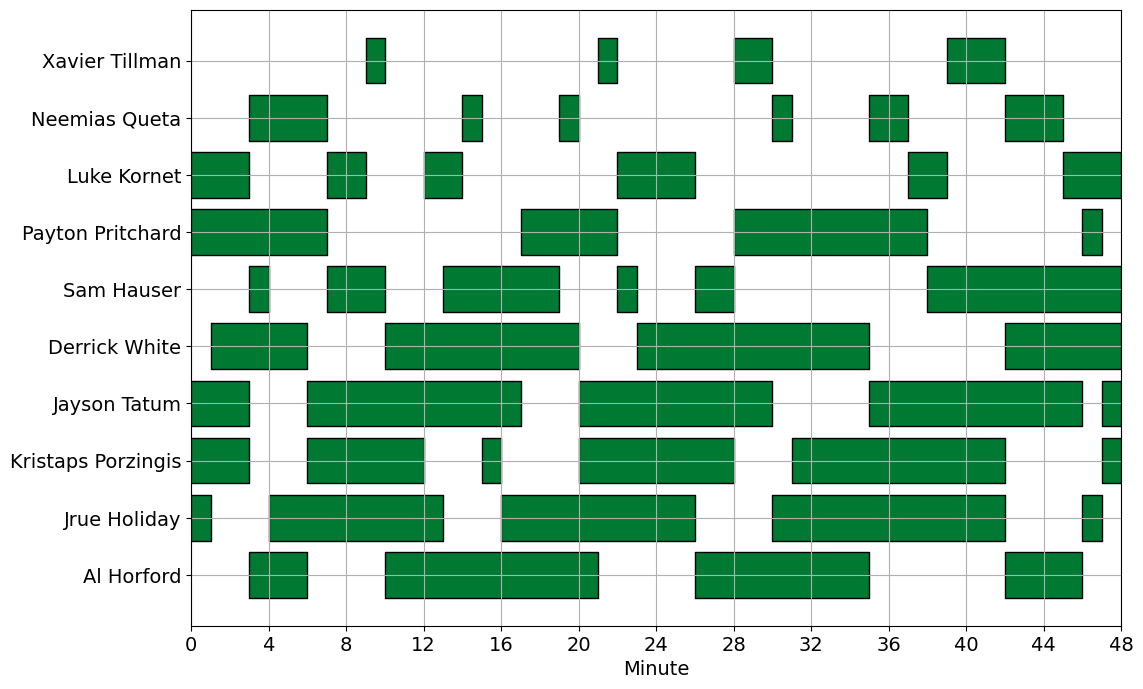

In [89]:
# Prepare data for plotting
player_time_slots = {}
for (lineup, time_slot), value in optimal_schedule.items():
    if value > 0:
        players = player_groups.get(lineup, [])
        for player in players:
            if player not in player_time_slots:
                player_time_slots[player] = []
            player_time_slots[player].append(time_slot)
# Create the Gantt chart
fig, ax = plt.subplots(figsize=(12, 8))
# Create a dictionary to map player names to y-axis positions
player_positions = {nba_players_dict[player]: idx for idx, player in enumerate(player_time_slots.keys())}
# Plot each player's time slots
for player, time_slots in player_time_slots.items():
    time_slots.sort()
    start = time_slots[0]
    for i in range(1, len(time_slots)):
        if time_slots[i] != time_slots[i-1] + 1:
            ax.broken_barh([(start, time_slots[i-1] - start + 1)], (player_positions[nba_players_dict[player]] - 0.4, 0.8), facecolors='#007A33', edgecolor="black")
            start = time_slots[i]
    ax.broken_barh([(start, time_slots[-1] - start + 1)], (player_positions[nba_players_dict[player]] - 0.4, 0.8), facecolors='#007A33', edgecolor="black")
# Customize the plot
ax.set_xlabel('Minute', fontsize=14)
# ax.set_ylabel('Player')
# ax.set_title('Player Stints')
ax.set_yticks(list(player_positions.values()))
ax.set_yticklabels(list(player_positions.keys()))
ax.set_xticks(range(0, 49, 4))
ax.set_xlim(0, 48)
plt.tick_params(axis='both', which='major', labelsize=14)
ax.grid(True)
plt.show()